<a href="https://colab.research.google.com/github/nedokormysh/NLP_Fontanka/blob/main/Pymagic_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install natasha -q
!pip install catboost -q

In [23]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS
import datetime

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

from catboost import CatBoostClassifier

from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.fasttext import FastText
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder, label_binarize
# from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

from sklearn.model_selection import KFold,\
                                    StratifiedKFold, cross_val_score, \
                                    ShuffleSplit, StratifiedShuffleSplit,\
                                    RandomizedSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
    precision_score, recall_score, f1_score, roc_auc_score, log_loss, auc,\
    roc_curve, confusion_matrix, ConfusionMatrixDisplay

import requests

from typing import List, Optional, Tuple, Union

import pickle

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Загрузка данных

Загрузка и логика обработки были рассмотрены в ноутбуке EDA

In [ ]:
df = pd.DataFrame()

In [ ]:
for i in range(45):
    df_ = pd.read_csv(f'https://github.com/nedokormysh/NLP_Fontanka/raw/main/data/fontanka_intermediate_{i}.csv')
    df = pd.concat([df, df_])

Хотим решать задачу классификации текстов по темам.

Предположим бизнес-задачу: тэгирование текстов.


In [ ]:
df['topic']= df['topic'].apply(lambda x: x.lower())
df.dropna(inplace=True)
df.isna().any().any()

False

In [ ]:
# Получаем топ 10 топиков по количеству
topic_counts = df.topic.value_counts()
top_topics = topic_counts.head(10)
df = df[df.topic.isin(top_topics.index)]

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
# df['date'] = df['datetime'].dt.date
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.strftime("%B")
df['weekday'] = df['datetime'].dt.strftime('%A')
df['hour'] = df['datetime'].dt.hour

In [ ]:
df['log_views'] = np.log1p(df['views'])

In [ ]:
df['len_title'] = df['title'].str.len()
df['len_content'] = df['content'].str.len()

In [ ]:
df['lifetime'] = pd.to_datetime(df['datetime'], utc=True).apply(lambda x: (datetime.datetime.now(datetime.timezone.utc) - x).total_seconds())
df['lifetime'] = df['lifetime'].apply(lambda x: divmod(x, 60)[0]) # в минутах

In [ ]:
df['views_by_minutes'] = (df['views'] + 1) / df['lifetime']
df['log_views_by_minutes'] = np.log1p(df['views_by_minutes'])

# Преобработка текстов

In [ ]:
RND_STATE = 7575

In [ ]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

In [ ]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык'])

In [ ]:
def text_prep(text: str) -> str:
    """
    Функция предобработки текста: лемматизация, фильтрация от стоп-слов

    :param text: строка текста
    :return: обработанная строка текста
    """
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    lemmas = [_.lemma for _ in doc.tokens]
    words = [lemma for lemma in lemmas if lemma.isalpha() and len(lemma) > 2]
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [ ]:
%%time
df['title_clean'] = df.title.apply(text_prep)
df['content_clean'] = df.content.apply(text_prep)

CPU times: user 42min 24s, sys: 25min 10s, total: 1h 7min 34s
Wall time: 39min 40s


In [ ]:
# Заголовок
df.sample(1)[['title', 'title_clean']].values

array([['В Пулково задержали жителя Израиля. Интерпол помог установить, под каким именем его помнят в Петербурге',
        'пулково задержать житель израиль интерпол помочь установить имя помнить петербург']],
      dtype=object)

In [ ]:
# Содержание
df.sample(1)[['content', 'content_clean']].values

array([['Способы облегчить зимнюю уборку в Петербурге становятся все оригинальнее. На битву с наледью пришлось призвать строительный кран, рассказал 4 февраля в соцсетях очевидец.«Строители приходят на помощь коммунальщикам», — лаконично прокомментировал он видео, опубликованное в группе «Признавашки ДТП и ЧП Санкт-Петербург» во «ВКонтакте». На кадрах кран сбивает со здания сосульки, а автор отмечает, что таким образом недолго и кровлю повредить. «Фонтанка» уже рассказывала о ноу-хау, с помощью которого сбивали сосульки на Петроградской стороне. Рабочие использовали «нанолопату», подвешенную на веревке.',
        'способ облегчить зимний уборка петербург становиться оригинальнее битва наледь прийтись призвать строительный кран рассказать февраль соцсеть очевидец строитель приходить помощь коммунальщик лаконично прокомментировать видео опубликовать группа признавашки дтп вконтакте кадр кран сбивать здание сосулька автор отмечать образ недолго кровля повредить фонтанка рассказывать помощ

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45472 entries, 0 to 1039
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   url                   45472 non-null  object             
 1   title                 45472 non-null  object             
 2   content               45472 non-null  object             
 3   topic                 45472 non-null  object             
 4   datetime              45472 non-null  datetime64[ns, UTC]
 5   views                 45472 non-null  int64              
 6   comments_amount       45472 non-null  int64              
 7   year                  45472 non-null  int32              
 8   month                 45472 non-null  object             
 9   weekday               45472 non-null  object             
 10  hour                  45472 non-null  int32              
 11  log_views             45472 non-null  float64            
 12  len_title 

# Вспомогательные функции и классы

Собственный класс для выбора колонок. Т.к. для разных моделей захотелось использовать разные колонки, то будем использовать этот класс

In [3]:
class CustomSelectColumns():
    """
    Класс выбора требуемых колонок
    """
    def __init__(self,
                 selected_feats: List[str] = None):
        """
        :param selected_feats: лист с выбранными признаками
        """
        self.sel_feats = selected_feats
        # print('Init done')
    def fit(self,
            X: pd.DataFrame,
            y: pd.Series = None):
        """
        метод применения класса
        :param X: датасет
        :param y: целевая переменная
        :return: экземпляр класса CustomSelectColumns
        """
        return self

    def transform(self,
                  X: pd.DataFrame,
                  y: pd.Series = None) -> pd.DataFrame:
        """
        метод трансформации датасета
        :param X: датасет
        :param y: целевая переменная
        :return: изменённый датасет
        """
        X_ = X.copy()
        X_filtered = X_[self.sel_feats]
        X_filtered = pd.DataFrame(X_filtered)
        return pd.DataFrame(X_filtered)

Будем трансформировать колонки: масштабировать численные переменные, категориальные кодировать, а текстовые либо создавать токены, либо не изменять.
Собственный класс для трансформации колонок.

In [4]:
class CustomTransformer():
    """
    Класс трансформации признаков.
    Числовые данные нормализуются или стандартизируются.
    Категориальные признаки не изменяются.
    После трансформаци возвращается датафрейм.
    """
    def __init__(self,
                 scaler_type: Union[StandardScaler, MinMaxScaler] = None,
                 cat_feats: List[str] = ['month', 'weekday'],
                 txt_feats: List[str] = ['content'],
                 split: bool = False,
                 with_mean: bool = True,
                 with_std: bool = True,
                 feature_range: tuple[int, int]=(0, 1)) -> None:

        """
        :param scaler_type: экземпляр класса мастшабирования или стандартизации
        :param cat_feats: лист с категориальными признаками
        :param txt_feats: лист с текстовыми призаками
        :param split: логическая переменная разбивать строку на токены
        :param with_mean: логическая переменная StandardScaler
                          - вычитать среднее значение
        :param with_std: логическая переменная StandardScaler
                          - делить на стандартное отклоннение
        :param feature_range: параметр класса MinMaxScaler
                          - диапазоном значений, на который масштабируются
                          признаки
        """

        self.scaler_type = scaler_type
        if scaler_type:
            self.scaler = StandardScaler(with_mean=with_mean, with_std=with_std)
        else:
            self.scaler = MinMaxScaler(feature_range=feature_range)

        self.split = split

        self.cat_encoder = LabelEncoder()
        self.cat_feats = cat_feats
        self.txt_feats = txt_feats

        # print('Init done')
    def fit(self,
            X: pd.DataFrame,
            y: pd.Series = None):
        """
        метод применения класса
        :param X: датасет
        :param y: целевая переменная
        :return: экземпляр класса CustomSelectColumns
        """
        return self

    def transform(self,
                  X: pd.DataFrame,
                  y: pd.Series=None) -> pd.DataFrame:
        """
        метод трансформации датасета
        :param X: датасет
        :param y: целевая переменная
        :return: изменённый датасет
        """

        X_ = X.copy()
        X_cat = X_[self.cat_feats]
        # категориальные признаки кодируем label_encoder
        for feature in self.cat_feats:
            # X_cat[feature + '_encoded'] = self.cat_encoder.fit_transform(X_cat[feature])
            X_.loc[:, feature + '_encoded'] = self.cat_encoder.fit_transform(X_[feature])
            X_cat = X_cat.drop(columns=[feature])

        num_feats = [i for i in X_.columns if i not in self.cat_feats and i not in self.txt_feats]
        # числовые признаки масштабируем
        X_num = X_[num_feats]

        X_num = pd.DataFrame(self.scaler.fit_transform(X_num), columns=num_feats)
        # текстовые признаки либо разбиваем на токены, либо оставляем так как есть
        if self.split:
            X_txt = X_[self.txt_feats].str.split()
        else:
            X_txt = X_[self.txt_feats]

        X_cat = X_cat.reset_index(drop=True)
        X_num = X_num.reset_index(drop=True)
        X_txt = X_txt.reset_index(drop=True)

        res = pd.concat([X_cat, X_num, X_txt], axis=1)
        return res.reset_index().set_index('index')

Будем создавать tf-idf вектора наших текстов. Собственный класс для получения взвешенных tfidf векторов.
Этот класс для преобразования текстовых данных в числовые векторы, которые могут быть использованы в качестве входных данных для машинного обучения. Он объединяет преимущества TF-IDF (для учета важности слов в тексте) и вложений слов (для учета семантического смысла слов).

In [5]:
class TfidfEmbeddingVectorizer(object):
    """Класс для получения взвешенных tfidf векторов предложения"""
    def __init__(self,
                 model,
                 column):
        """
        :param model: модель для получения векторных представлений слов
        :param column: колонка, к которой применяем
        """
        self.word2vec = model.wv
        self.word2weight = None
        self.dim = model.vector_size
        self.column = column
        self.max_idf = None

    def tokenize(self, x: List[str]):
        """
        метод для токенизирования, но будем подавать уже токенезированный текст
        :return: лист слов предложения
        """
        return x

    def get_idf(self, tfidf, word):
        index = tfidf.vocabulary_.get(word)
        return tfidf.idf_[index] if index is not None else self.max_idf

    def default_idf(self):
        return self.max_idf

    def fit(self,
            X: pd.DataFrame,
            y: pd.Series):
        """
        метод применения класса
        :param X: датасет
        :param y: целевая переменная
        :return: экземпляр класса CustomSelectColumns
        """
        tfidf = TfidfVectorizer(analyzer=self.tokenize)
        tfidf.fit(X[self.column])
        self.max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            self.default_idf,
            [(w, self.get_idf(tfidf, w)) for w in tfidf.vocabulary_.items()])

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        метод трансформации датасета
        :param X: датасет
        :return: изменённый датасет
        """
        X_tfidf = np.array([
                np.mean([self.word2vec.get_vector(w) * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X[self.column]
            ])
        X_tfidf = pd.DataFrame(X_tfidf, columns=[f'tfidf_{i}' for i in range(self.dim)])
        X.drop(self.column, inplace=True, axis=1)
        X = pd.concat([X, X_tfidf], axis=1)

        return X

In [6]:
def get_metrics_multiclass(y_test_bin: np.array,
                           y_test: np.array,
                           y_pred: np.array,
                           y_prob: np.array,
                           name: str,
                           type_multi: str):
    """

    :param y_test_bin: бинаризованные тестовые метки класса
    :param y_test: метки класса без бинаризации
    :param y_prob: предсказанные вероятности классов
    :param name: - название модели/подхода
    :param type_multi: тип многоклассовой классификации для ROC-AUC (ovo/ovr)
    """

    df_metrics = pd.DataFrame()


    df_metrics['model'] = [name]

    df_metrics['ROC_AUC'] = roc_auc_score(y_test_bin,
                                          y_prob,
                                          multi_class=type_multi)

    df_metrics['Precision_micro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='micro')
    df_metrics['Precision_macro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='macro')

    df_metrics['Recall_micro'] = recall_score(y_test, y_pred, average='micro')
    df_metrics['Recall_macro'] = recall_score(y_test, y_pred, average='macro')

    df_metrics['F1_micro'] = f1_score(y_test, y_pred, average='micro')
    df_metrics['F1_macro'] = f1_score(y_test, y_pred, average='macro')
    df_metrics['F1_weighted'] = f1_score(y_test, y_pred, average='weighted')

    df_metrics['Logloss'] = log_loss(y_test, y_prob)

    return df_metrics

# Преобработка данных

In [13]:
df = pd.read_csv('/content/prep.csv')
RND_STATE = 7575

In [14]:
# инициализируем листы числовых, категориальных, целевых признаков и признаки,
# которые не потребуются для анализа
cat_features = [#'title',
                #'content',
                'month',
                'weekday']
# cat_features_indxs = [0, 1, 2]
targets = ['topic',
          #  'views'
           ]
features2drop = ['url', 'views', 'views_by_minutes', 'lifetime', 'datetime',
                 'title', 'title_clean']

filtered_features = [i for i in df.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print(f'\033[1mcat_features:\033[0m {cat_features}, \033[1mamount\033[0m = {len(cat_features)}')
print(f'\033[1mnum_features:\033[0m {num_features}, \033[1mamount\033[0m = {len(num_features)}')
print(f'\033[1mtargets:\033[0m {targets}, \033[1mamount\033[0m = {len(targets)}')

cat_features: ['month', 'weekday'], amount = 2
num_features: ['content', 'comments_amount', 'year', 'hour', 'log_views', 'len_title', 'len_content', 'log_views_by_minutes', 'content_clean'], amount = 9
targets: ['topic'], amount = 1


In [ ]:
# df.info()

In [15]:
# Заменим тип данных object на category в категориальных признаках

for col in cat_features:
    df[col] = df[col].astype("category")

for col in cat_features:
    df[col] = df[col].astype("category")

In [16]:
# получаем разбиение на фичи и целевую переменную
X = df[filtered_features].drop(targets, axis=1, errors="ignore")
y = df["topic"]

# разбиение на обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=RND_STATE,
                                                    shuffle=True)

In [18]:
# кодируем целевую переменную
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num = le.transform(y_test)

In [19]:
selected_columns_1 = ['comments_amount',
                      'year',
                      'month',
                      'weekday',
                      'hour',
                      'log_views',
                      'len_title',
                      'len_content',
                      'log_views_by_minutes',
                      # 'title_clean',
                      'content_clean']

# Модели

In [15]:
# model = Word2Vec(sentences=X_train['content_clean'].str.split(),
#                  vector_size=300,
#                  min_count=10,
#                  window=5000,
#                  seed=RND_STATE)

Загрузим модель, которую уже обучали в Pymagic_baseline

In [21]:
url = 'https://github.com/nedokormysh/NLP_Fontanka/raw/main/Models/Base/model.pkl'
response = requests.get(url)

with open('model.pkl', 'wb') as f:
    f.write(response.content)

In [22]:
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

Рассмотрим разные модели в качестве базовых алгоритмов.

In [110]:
parameters_grid = [{
    'clf__C':  np.logspace(-3, 3, num=5),
    'clf__kernel': ['linear', 'poly',
                          'rbf',
                          'sigmoid'
                          ],
    'clf__degree': [2, 3, 4],
    'clf__decision_function_shape': ['ovo', 'ovr'],
    'clf__max_iter': [100, 1000, 10000],
    'clf__class_weight': ['balanced'],
    'clf__random_state': [RND_STATE]
}]

pipe_svc = Pipeline([('selector', CustomSelectColumns(selected_columns_1)),
                 ('preprocessor', CustomTransformer(True, txt_feats='content_clean', split=True)),
                 ('tfidf', TfidfEmbeddingVectorizer(model, column='content_clean')),
                 ('clf', SVC(random_state=RND_STATE))])

# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RND_STATE)

# # scoring - метрика, по которой выбираете лучшее решение
rand_cv = RandomizedSearchCV(pipe_svc,
                       parameters_grid,
                       scoring='f1_weighted',
                      #  cv=cv,
                       verbose=2,
                       n_jobs=-1)

In [111]:
%time
# производим обучение по сетке
rand_cv.fit(X_train, y_train_num)
y_pred_num = rand_cv.predict(X_test)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11.7 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [112]:
print('Лучшие значения параметров:', rand_cv.best_params_)
print('Best score:', rand_cv.best_score_)

Лучшие значения параметров: {'clf__random_state': 7575, 'clf__max_iter': 1000, 'clf__kernel': 'rbf', 'clf__degree': 3, 'clf__decision_function_shape': 'ovr', 'clf__class_weight': 'balanced', 'clf__C': 31.622776601683793}
Best score: 0.6427131001953372


In [101]:
print(classification_report(y_test_num, y_pred_num, target_names=le.classes_))

               precision    recall  f1-score   support

         авто       0.01      0.25      0.02         4
       бизнес       0.28      0.50      0.36        52
       власть       0.26      0.07      0.11       100
        город       0.62      0.50      0.55       238
     общество       0.66      0.16      0.26       370
     политика       0.15      0.97      0.25        31
 происшествия       0.76      0.72      0.74       322
        спорт       0.83      0.93      0.88        61
строительство       0.07      0.50      0.12         6
      финансы       0.19      0.75      0.30        24

     accuracy                           0.46      1208
    macro avg       0.38      0.54      0.36      1208
 weighted avg       0.61      0.46      0.47      1208



In [85]:
np.unique(y_pred_num)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [113]:
np.arange(0, 10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# # сохраняем модель в файл
# with open('pipe_svc.pkl', 'wb') as file:
#     pickle.dump(pipe_lr_base, file)

In [86]:
n_classes = len(set(y))
y_test_bin = label_binarize(y_test_num, classes=np.arange(0, 10))

In [102]:
y_score = rand_cv.decision_function(X_test)

metrics = get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='SVC_RandomizedSearch',
                       type_multi='ovr'
)
metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted,Logloss
0,SVC_RandomizedSearch,0.890465,0.458609,0.381526,0.458609,0.535793,0.458609,0.36001,0.467947,2.200638


In [103]:
np.shape(y_pred_num)

(1208,)

In [104]:
np.shape(y_score)

(1208, 10)

In [105]:
np.shape(y_test_bin)

(1208, 10)

In [93]:
f = rand_cv.predict_proba(X_test)

AttributeError: predict_proba is not available when  probability=False

In [77]:
roc_auc_score(y_test_bin,
                                          y_score,
                                          multi_class='ovo')

# df_metrics['Precision_micro'] = precision_score(y_test,
#                                                     y_pred,
#                                                     average='micro')
# df_metrics['Precision_macro'] = precision_score(y_test,
#                                                     y_pred,
#                                                     average='macro')

#     df_metrics['Recall_micro'] = recall_score(y_test, y_pred, average='micro')
#     df_metrics['Recall_macro'] = recall_score(y_test, y_pred, average='macro')

#     df_metrics['F1_micro'] = f1_score(y_test, y_pred, average='micro')
#     df_metrics['F1_macro'] = f1_score(y_test, y_pred, average='macro')
#     df_metrics['F1_weighted'] = f1_score(y_test, y_pred, average='weighted')

#     df_metrics['Logloss'] = log_loss(y_test, y_prob)

IndexError: index 10 is out of bounds for axis 1 with size 10

## CatBoost

In [ ]:
%time
pipe_catboost = Pipeline([('selector', CustomSelectColumns(selected_columns_1)),
                 ('preprocessor', CustomTransformer(True, txt_feats='content_clean', split=True)),
                 ('tfidf', TfidfEmbeddingVectorizer(model_fast, column='content_clean')),
                 ('clf', CatBoostClassifier(random_state=RND_STATE,
                                            auto_class_weights='Balanced',
                                            loss_function='MultiClass',
                                            verbose=False))])

pipe_catboost.fit(X_train, y_train_num)

y_pred_num = pipe_catboost.predict(X_test)
print(classification_report(y_test_num, y_pred_num, target_names=le.classes_))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs
               precision    recall  f1-score   support

         авто       0.48      0.74      0.58       150
       бизнес       0.47      0.72      0.57       401
       власть       0.47      0.60      0.52       910
        город       0.73      0.75      0.74      1949
     общество       0.69      0.51      0.59      3315
     политика       0.30      0.41      0.35       235
 происшествия       0.84      0.86      0.85      3769
        спорт       0.85      0.93      0.89       393
строительство       0.90      0.90      0.90       114
      финансы       0.40      0.68      0.50       132

     accuracy                           0.70     11368
    macro avg       0.61      0.71      0.65     11368
 weighted avg       0.72      0.70      0.70     11368



In [ ]:
# сохраняем модель в файл
with open('pipe_catboost.pkl', 'wb') as file:
    pickle.dump(pipe_lr_base, file)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


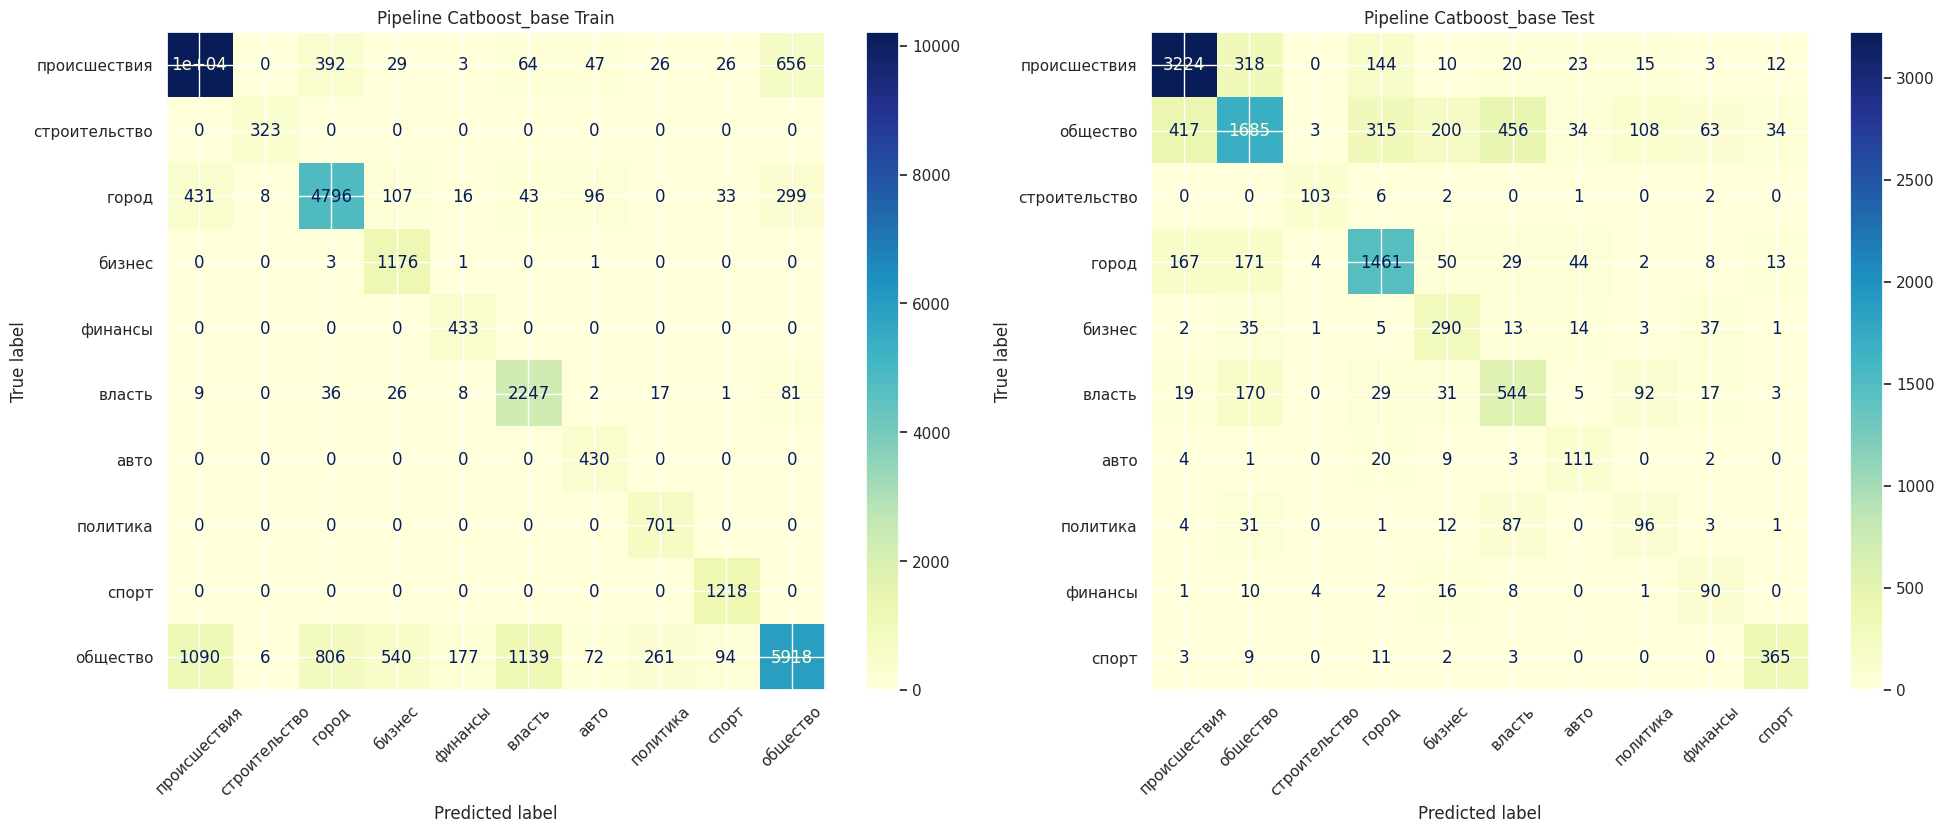

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

plot_confusion_matrix(model=pipe_catboost,
                      y_true=y_train_num,
                      X=X_train,
                      ax=ax[0],
                      cmap='YlGnBu')
plot_confusion_matrix(model=pipe_catboost,
                      y_true=y_test_num,
                      X=X_test,
                      ax=ax[1],
                      cmap='YlGnBu')

ax[0].title.set_text(type(pipe_catboost).__name__ + ' Catboost_base' + ' Train')
ax[1].title.set_text(type(pipe_catboost).__name__ + ' Catboost_base' + ' Test')

for a in ax:
    plt.sca(a)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
y_score = pipe_catboost.predict_proba(X_test)

metrics = pd.concat([
    metrics,
    get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='Catboost_Baseline',
                       type_multi='ovr')
])

metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,LogisticRegresstion_Baseline,0.886100,0.648575,0.552894,0.648575,0.721752,0.648575,0.594695,1.895231
0,SVC_Baseline,0.937901,0.666344,0.567285,0.666344,0.740458,0.666344,0.611043,2.172513
0,Catboost_Baseline,0.955769,0.701003,0.612723,0.701003,0.709690,0.701003,0.648759,0.768714


# Multilabel

Предобработаем датасет для уменьшения времени работы.

In [ ]:
preprocessor = Pipeline([('selector', CustomSelectColumns(selected_columns_1)),
                         ('preprocessor', CustomTransformer(True, txt_feats='content_clean', split=True)),
                         ('tfidf', TfidfEmbeddingVectorizer(model, column='content_clean'))])

X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

## One vs Rest

In [1]:
# # создаем препроцессор
# preprocessor = Pipeline([
#     ('selector', CustomSelectColumns(selected_columns_1)),
#     ('preprocessor', CustomTransformer(True, txt_feats='content_clean', split=True)),
#     ('tfidf', TfidfEmbeddingVectorizer(model, column='content_clean'))
# ])

# # создаем классификатор
# clf = LogisticRegression(random_state=RND_STATE, max_iter=10000)
# ovr_clf = OneVsRestClassifier(clf)

# # создаем пайплайн
# pipeline = make_pipeline(preprocessor, ovr_clf)

# # задаем параметры для поиска
# param_dist = {
#     'onevsrestclassifier__estimator__C': [0.01, 0.1, 1, 10, 100],
#     'onevsrestclassifier__estimator__penalty': ['l1', 'l2'],
#     'onevsrestclassifier__estimator__solver': ['liblinear', 'saga'],
#     'onevsrestclassifier__estimator__class_weight': ['balanced', None]
# }

# # создаем и запускаем RandomizedSearchCV
# n_iter_search = 10
# random_search = RandomizedSearchCV(
#     pipeline,
#     param_distributions=param_dist,
#     scoring='f1_weighted',
#     n_iter=n_iter_search,
#     # cv=3,
#     random_state=RND_STATE)
# random_search.fit(X_train, y_train_num)

# # получаем лучшие гиперпараметры
# best_params = random_search.best_params_

NameError: name 'Pipeline' is not defined

In [ ]:
# создаем пайплайн
clf = LogisticRegression(random_state=RND_STATE, max_iter=10000)
ovr_clf = OneVsRestClassifier(clf)
pipeline = make_pipeline(ovr_clf)

# задаем параметры для поиска
param_dist = {
    'onevsrestclassifier__estimator__C': [0.01, 0.1, 1, 10, 100],
    'onevsrestclassifier__estimator__penalty': ['l1', 'l2'],
    'onevsrestclassifier__estimator__solver': ['liblinear', 'saga'],
    'onevsrestclassifier__estimator__class_weight': ['balanced', None]
}

# создаем и запускаем RandomizedSearchCV
n_iter_search = 10
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist,
    n_iter=n_iter_search, cv=3, random_state=RND_STATE)
random_search.fit(X_train_preprocessed, y_train_num)

# получаем лучшие гиперпараметры
best_params = random_search.best_params_

In [ ]:
# сохраняем модель в файл
with open('ovr_lr.pkl', 'wb') as file:
    pickle.dump(ovr, file)

In [ ]:
y_pred_num = ovr.predict(X_test_preprocessed)
y_score = ovr.decision_function(X_test_preprocessed)

metrics = pd.concat([
    metrics,
    get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='OVR_LogReg_Baseline',
                       type_multi='ovr')
])

# metrics

In [ ]:
metrics = metrics.reset_index(drop=True)
metrics = metrics.set_index("model")
metrics = metrics.sort_values("ROC_AUC", ascending=False)

def highlight_max(s):
    is_max = s == s.max()
    return ["background-color: yellow" if v else "" for v in is_max]

styled_metrics = metrics.style.apply(highlight_max, subset=["ROC_AUC"])

styled_metrics

,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
model,,,,,,,,
Catboost_Baseline,0.955769,0.701003,0.612723,0.701003,0.709690,0.701003,0.648759,0.768714
OVR_LogReg_Baseline,0.952617,0.675317,0.574220,0.675317,0.707011,0.675317,0.612117,5.126163
Catboost_txt_Baseline,0.951006,0.680771,0.589401,0.680771,0.746439,0.680771,0.636589,0.854864
SVC_Baseline,0.937901,0.666344,0.567285,0.666344,0.740458,0.666344,0.611043,2.172513
OVO_LogReg_Baseline,0.934605,0.663089,0.573897,0.663089,0.717059,0.663089,0.612543,2.191294
LogisticRegresstion_Baseline,0.886100,0.648575,0.552894,0.648575,0.721752,0.648575,0.594695,1.895231


**Выводы:**
- Будем смотреть на метрику ROC_AUC. У нас нет предпочтений насчёт точности или полноты классификации статей.
- По этой метрике у нас лучше всего отработал вариант базового Catboost. Если подавать тектовые результаты с в Catboost в качестве текстовых признаков, то результаты были хорошими, но скорость значительно ниже, впрочем размер самой сохранённой модели был также ниже. В дальнейшем будем использовать вариант с предобработкой.
- Также достаточно неплохо себя проявила логистическая регрессия с использованием метамодели OVR. При этом логистическая регрессия без метамодели показала худший результат для данной задачи. Также следует отметить, что если не балансировать классы, то логистическая регрессия без метамодели по ROC_AUC метрике улучшала результаты до 0.9
- Неплохо показала себя модель SVC. Можно взять для стекинга моделей.